<a href="https://colab.research.google.com/github/nikitazhuikov/ML-projects/blob/main/TitanikSklearnML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from tqdm import tqdm

In [20]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from sklearn.model_selection import GridSearchCV

In [21]:
from tpot import TPOTClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, f1_score, confusion_matrix

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
# генерация фичей
titanic_df = pd.read_csv('Titanic-Dataset.csv', usecols=['Pclass', 'Survived', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'])
embarked_mode = titanic_df['Embarked'].mode()[0]
titanic_df['Embarked'].fillna(embarked_mode, inplace=True)
age_median = titanic_df['Age'].median()
titanic_df['Age'].fillna(age_median, inplace=True)
titanic_df['Sex'] = pd.factorize(titanic_df['Sex'])[0]
# Создание FamilySize
titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1
# Создание IsAlone
titanic_df['IsAlone'] = (titanic_df['FamilySize'] == 1).astype(int)
titanic_df = pd.get_dummies(titanic_df, columns=['Embarked', 'Pclass'], drop_first=True)
numerical_cols = titanic_df[['Age', 'Fare', 'FamilySize']].columns
titanic_df = titanic_df.drop(['SibSp', 'Parch'], axis=1)

C:\Users\User\AppData\Local\Temp\ipykernel_1652\2519178512.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_df['Embarked'].fillna(embarked_mode, inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_1652\2519178512.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

In [24]:
# нормализация
titanic_df[numerical_cols] = StandardScaler().fit_transform(titanic_df[numerical_cols])

In [25]:
titanic_df

,Survived,Sex,Age,Fare,FamilySize,IsAlone,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,0,0,-0.565736,-0.502445,0.059160,0,False,True,False,True
1,1,1,0.663861,0.786845,0.059160,0,False,False,False,False
2,1,1,-0.258337,-0.488854,-0.560975,1,False,True,False,True
3,1,1,0.433312,0.420730,0.059160,0,False,True,False,False
4,0,0,0.433312,-0.486337,-0.560975,1,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...
886,0,0,-0.181487,-0.386671,-0.560975,1,False,True,True,False
887,1,1,-0.796286,-0.044381,-0.560975,1,False,True,False,False
888,0,1,-0.104637,-0.176263,1.299429,0,False,True,False,True
889,1,0,-0.258337,-0.044381,-0.560975,1,False,False,False,False


In [26]:
x = titanic_df.drop('Survived', axis = 1)

In [27]:
mlflow.set_tracking_uri("http://127.0.0.1:5001")
mlflow.set_experiment("log_reg")


<Experiment: artifact_location='mlflow-artifacts:/189883142389238581', creation_time=1743612627305, experiment_id='189883142389238581', last_update_time=1743612627305, lifecycle_stage='active', name='log_reg', tags={}>

In [28]:
y = titanic_df['Survived']

In [29]:
x_train, x_test, y_train,  y_test = train_test_split(x, y, test_size=0.3)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)

In [35]:
def mdl_metrics(y_true, y_pred, dataset_name="Dataset"):
    print(f"--- Метрики для {dataset_name} ---")
    metrics_dict = {} # Dictionary to store metrics for MLflow logging
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1-Score (weighted): {f1:.4f}")
    metrics_dict[f"{dataset_name}_accuracy"] = accuracy
    metrics_dict[f"{dataset_name}_precision"] = precision
    metrics_dict[f"{dataset_name}_recall"] = recall
    metrics_dict[f"{dataset_name}_f1_score"] = f1
    return metrics_dict # Return the metrics dictionary for logging

In [36]:
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0], 
    'max_iter': [100, 200, 500], 
    'penalty': ['l2'] 
    }
logreg_estimator = LogisticRegression(solver='liblinear')
grid_search = GridSearchCV(estimator=logreg_estimator, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
with mlflow.start_run(run_name="Log_reg_best"):
    grid_search.fit(x_train, y_train)
    best_params = grid_search.best_params_
    best_score_cv = grid_search.best_score_
    mlflow.log_params(best_params)
    mlflow.log_metric("best_cv_accuracy", best_score_cv)
    print(f"Лучшие параметры, найденные GridSearchCV: {best_params}")
    print(f"Лучший средний результат кросс-валидации (Accuracy): {best_score_cv:.4f}")
    best_mdl = grid_search.best_estimator_

    y_train_pred = best_mdl.predict(x_train)
    validation_metrics = mdl_metrics(y_train, y_train_pred, dataset_name="Train")
    mlflow.log_metrics(metrics)    
    
    y_val_pred = best_mdl.predict(x_val)
    validation_metrics = mdl_metrics(y_val, y_val_pred, dataset_name="Validation")
    mlflow.log_metrics(metrics)
    
    y_test_pred = best_mdl.predict(x_test)
    validation_metrics = mdl_metrics(y_test, y_test_pred, dataset_name="Test")
    mlflow.log_metrics(validation_metrics)

Лучшие параметры, найденные GridSearchCV: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2'}
Лучший средний результат кросс-валидации (Accuracy): 0.8250
--- Метрики для Train ---
Accuracy: 0.8347
Precision (weighted): 0.8343
Recall (weighted): 0.8347
F1-Score (weighted): 0.8312
--- Метрики для Validation ---
Accuracy: 0.7612
Precision (weighted): 0.7577
Recall (weighted): 0.7612
F1-Score (weighted): 0.7565
--- Метрики для Test ---
Accuracy: 0.7463
Precision (weighted): 0.7541
Recall (weighted): 0.7463
F1-Score (weighted): 0.7386
🏃 View run Log_reg_best at: http://127.0.0.1:5001/#/experiments/189883142389238581/runs/4b0439a5e8e5493c8ae87586444dd46a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/189883142389238581


In [15]:
accuracy = (TP + TN)/(TP + TN + FP + FN)
precision = TP  / (TP + FP)
recall = TP / (TP + FP)
sensitivity = TP / (TP + FN)

In [16]:
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)
print('sensitivity:', sensitivity)

accuracy: 0.7761194029850746
precision: 0.8333333333333334
recall: 0.8333333333333334
sensitivity: 0.603448275862069


In [17]:
# строим ROC-AUC
y_pred_proba = mdl.predict_proba(x_val)[:, 1]

NameError: name 'mdl' is not defined

In [57]:
comparison_df = pd.DataFrame({
    'Actual': y_val,
    'Predicted': y_pred,
    'Probability': y_pred_proba
})
comparison_df = comparison_df.sort_values('Probability', ascending=False)
comparison_df

,Actual,Predicted,Probability
307,1,1,0.965483
329,1,1,0.961344
291,1,1,0.960979
710,1,1,0.944051
435,1,1,0.912657
...,...,...,...
152,0,0,0.042349
94,0,0,0.037352
480,0,0,0.036557
116,0,0,0.028470


In [58]:
P = len(comparison_df[comparison_df['Actual']==0])
N = len(comparison_df[comparison_df['Actual']==0])

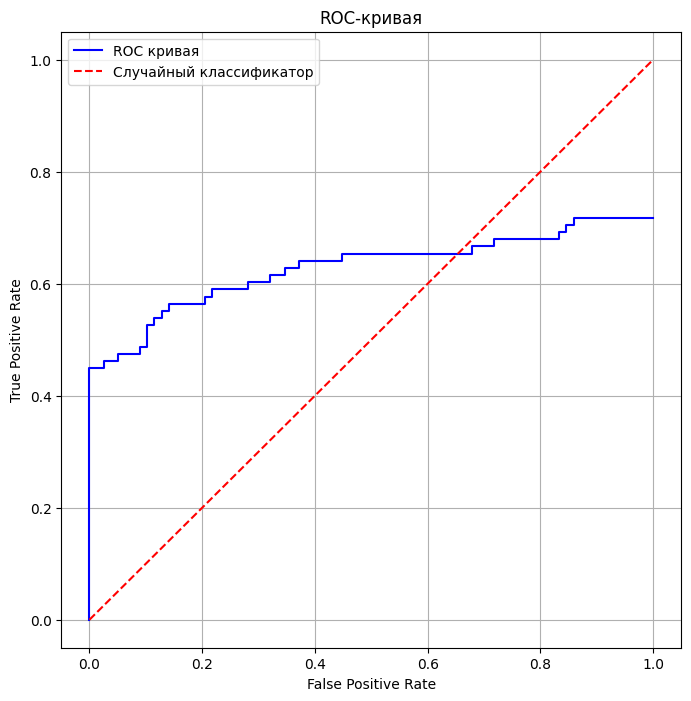

In [59]:
y = 0
x = 0
X = [x]
Y = [y]
for a in comparison_df['Actual']:
    if a == 1:
        y += 1/P
    else:
        x += 1/N
    X.append(x)
    Y.append(y)
# Строим график
plt.figure(figsize=(8, 8))
plt.plot(X, Y, 'b-', label='ROC кривая')
plt.plot([0, 1], [0, 1], 'r--', label='Случайный классификатор')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.grid(True)
plt.show()

is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1230: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1270: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(


is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier


Version 0.12.2 of tpot is outdated. Version 1.0.0 was released Wednesday February 26, 2025.


                                                                                                                       
Generation 1 - Current best internal CV score: 0.799367741935484
                                                                                                                       
Generation 2 - Current best internal CV score: 0.8089806451612904
                                                                                                                       
Generation 3 - Current best internal CV score: 0.8089806451612904
                                                                                                                       
Generation 4 - Current best internal CV score: 0.8121677419354839
                                                                                                                       
Generation 5 - Current best internal CV score: 0.8218580645161291
                                                                       

C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
2025/04/23 19:41:52 WARNING mlflow.models.model: Model logged without a signatur


Лучший пайплайн:
Pipeline(steps=[('stackingestimator',
                 StackingEstimator(estimator=RandomForestClassifier(bootstrap=False,
                                                                    max_features=0.6000000000000001,
                                                                    min_samples_leaf=5,
                                                                    min_samples_split=19,
                                                                    random_state=42))),
                ('randomforestclassifier',
                 RandomForestClassifier(max_features=0.2, min_samples_leaf=7,
                                        min_samples_split=4,
                                        random_state=42))])

Метрики на тестовом наборе:
accuracy: 0.507
precision: 0.261
recall: 0.273
roc_auc: 0.416
🏃 View run TPOT_AutoML at: http://127.0.0.1:5001/#/experiments/189883142389238581/runs/780148589be743089002c1728eae34d9
🧪 View experiment at: http://127.0.0.1:

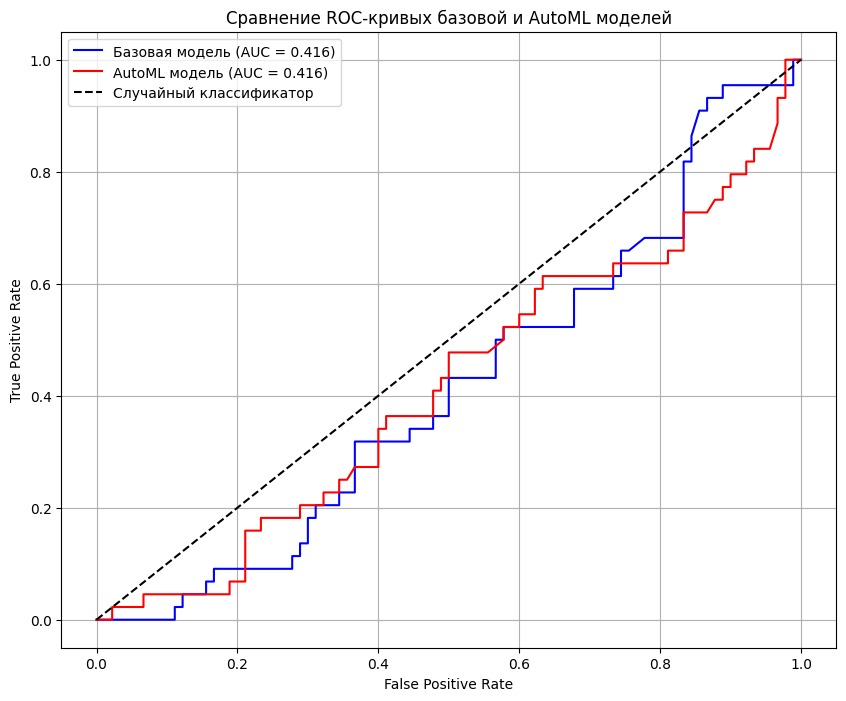

In [60]:
tpot = TPOTClassifier(
    generations=5,  # количество поколений для оптимизации
    population_size=20,  # размер популяции в каждом поколении
    cv=5,  # количество фолдов для кросс-валидации
    random_state=42,
    verbosity=2,
    n_jobs=-1  # использовать все доступные ядра процессора
)

# Запускаем MLflow эксперимент для отслеживания результатов
with mlflow.start_run(run_name="TPOT_AutoML"):
    # Обучаем TPOT
    tpot.fit(x_train, y_train)

    # Получаем предсказания
    y_pred_auto = tpot.predict(x_val)
    y_pred_proba_auto = tpot.predict_proba(x_val)[:, 1]

    # Вычисляем метрики
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred_auto),
        'precision': precision_score(y_test, y_pred_auto),
        'recall': recall_score(y_test, y_pred_auto),
        'roc_auc': roc_auc_score(y_test, y_pred_proba_auto)
    }

    # Логируем метрики
    mlflow.log_metrics(metrics)

    # Сохраняем лучший пайплайн
    mlflow.sklearn.log_model(tpot.fitted_pipeline_, "tpot_best_model")

    # Выводим результаты
    print("\nЛучший пайплайн:")
    print(tpot.fitted_pipeline_)
    print("\nМетрики на тестовом наборе:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.3f}")

# Построение ROC-кривой для сравнения моделей
plt.figure(figsize=(10, 8))

# ROC-кривая для базовой модели
fpr_base, tpr_base, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr_base, tpr_base, 'b-', label=f'Базовая модель (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')

# ROC-кривая для AutoML модели
fpr_auto, tpr_auto, _ = roc_curve(y_test, y_pred_proba_auto)
plt.plot(fpr_auto, tpr_auto, 'r-', label=f'AutoML модель (AUC = {metrics["roc_auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Случайный классификатор')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Сравнение ROC-кривых базовой и AutoML моделей')
plt.legend()
plt.grid(True)
plt.show()


### Отбор признаков

In [71]:
with mlflow.start_run(run_name="RandomForestClassifier"):
    mdl2 = RandomForestClassifier(criterion='entropy', max_features=0.2,
                                        min_samples_leaf=5, min_samples_split=4,
                                        random_state=42).fit(x_train, y_train)
    # Получаем предсказания
    y_pred_auto = mdl2.predict(x_test)
    y_pred_proba_auto = mdl2.predict_proba(x_test)[:, 1]

    # Вычисляем метрики
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred_auto),
        'precision': precision_score(y_test, y_pred_auto),
        'recall': recall_score(y_test, y_pred_auto),
        'roc_auc': roc_auc_score(y_test, y_pred_proba_auto)
    }

    # Логируем метрики
    mlflow.log_metrics(metrics)


🏃 View run RandomForestClassifier at: http://127.0.0.1:5001/#/experiments/189883142389238581/runs/287b2afbd99b4c9396e414c5fd62b175
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/189883142389238581


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Embarked_Q
- Embarked_S
- FamilySize
- IsAlone
- Pclass_2
- ...


In [62]:
feature_importance = mdl2.feature_importances_

In [63]:
feature_importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)
    
print(f"accuracy_score: {round(accuracy_score(y_test, y_pred_auto), 2)}")
display(feature_importance_df)

accuracy_score: 0.85


,Feature,Importance
0,Sex,0.335902
2,Fare,0.250456
1,Age,0.171832
8,Pclass_3,0.100990
3,FamilySize,0.064952
6,Embarked_S,0.027704
7,Pclass_2,0.024213
4,IsAlone,0.015825
5,Embarked_Q,0.008125


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.27it/s]


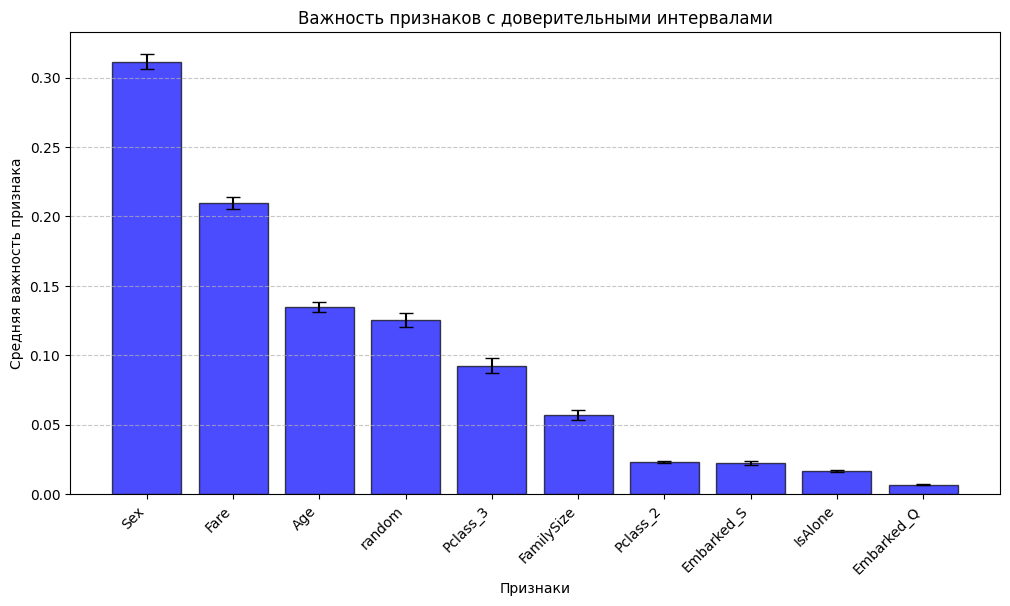

In [64]:
n_iterations = 10
features = list(x_train.columns) + ['random']

# Словарь для хранения значений важности признаков
feature_importance_records = {feature: [] for feature in features}

# Запускаем обучение много раз
for _ in tqdm(range(n_iterations)):
    x_train['random'] = np.random.random(size=len(x_train))
    mdl2 = RandomForestClassifier(criterion='entropy', max_features=0.2,
                                        min_samples_leaf=5, min_samples_split=4,
                                        random_state=42)
    mdl2.fit(x_train, y_train)

    # Получаем важность признаков
    feature_importance = mdl2.feature_importances_

    # Записываем значения в словарь
    for feature, importance in zip(x_train.columns, feature_importance):
        feature_importance_records[feature].append(importance)

# Создаём DataFrame с итоговыми средними и стандартными отклонениями
feature_importance_stats = pd.DataFrame({
    'feature': list(feature_importance_records.keys()),
    'mean': [np.mean(values) for values in feature_importance_records.values()],
    'std': [np.std(values) for values in feature_importance_records.values()]
}).sort_values(by='mean', ascending=False)

# display(feature_importance_stats)

plt.figure(figsize=(12, 6))
plt.bar(
    feature_importance_stats['feature'], 
    feature_importance_stats['mean'], 
    yerr=feature_importance_stats['std'], 
    capsize=5, 
    color='blue', 
    edgecolor='black', 
    alpha=0.7
)

plt.xlabel('Признаки')
plt.ylabel('Средняя важность признака')
plt.title('Важность признаков с доверительными интервалами')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Отображение графика
plt.show()

In [69]:
with mlflow.start_run(run_name="RandomForestClassifier_with3_top_features"):
    x_train = x_train[['Sex', 'Age', 'Fare']]
    x_test = x_test[['Sex', 'Age', 'Fare']]
    mdl3 = RandomForestClassifier(criterion='entropy', max_features=0.2,
                                        min_samples_leaf=5, min_samples_split=4,
                                        random_state=42).fit(x_train, y_train)
    # Получаем предсказания
    y_pred_auto = mdl3.predict(x_test)
    y_pred_proba_auto = mdl3.predict_proba(x_test)[:, 1]

    # Вычисляем метрики
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred_auto),
        'precision': precision_score(y_test, y_pred_auto),
        'recall': recall_score(y_test, y_pred_auto),
        'roc_auc': roc_auc_score(y_test, y_pred_proba_auto)
    }

    # Логируем метрики
    mlflow.log_metrics(metrics)

🏃 View run RandomForestClassifier_with3_top_features at: http://127.0.0.1:5001/#/experiments/189883142389238581/runs/ec41bf1eb5f346778c903f84fb922b22
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/189883142389238581


In [70]:
metrics

{'accuracy': 0.8134328358208955,
 'precision': 0.7567567567567568,
 'recall': 0.6363636363636364,
 'roc_auc': np.float64(0.8776515151515152)}